In [1]:
# 15m 收在下布林，且下影線大於實體Ｋ及上影線
# ! conda install -c conda-forge ta --yes
# ! conda update -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1678445903000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600 # 15min

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)

    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

              Close_Time     Open    Close     High      Low      Volume
0    2023-03-10 19:14:59  1379.55  1385.87  1387.49  1379.34  10754.4378
1    2023-03-10 19:29:59  1385.87  1380.99  1385.88  1375.70  11804.9683
2    2023-03-10 19:44:59  1380.98  1376.84  1383.42  1373.97   8421.8361
3    2023-03-10 19:59:59  1376.84  1384.60  1388.80  1376.70   9375.2541
4    2023-03-10 20:14:59  1384.61  1384.11  1386.49  1383.66   4387.7592
..                   ...      ...      ...      ...      ...         ...
650  2023-03-17 13:44:59  1700.30  1698.83  1700.99  1696.37   3739.3332
651  2023-03-17 13:59:59  1698.83  1703.27  1703.27  1698.38   3845.3244
652  2023-03-17 14:14:59  1703.27  1705.62  1707.14  1702.41   3504.9674
653  2023-03-17 14:29:59  1705.61  1705.83  1713.41  1704.31   9002.4122
654  2023-03-17 14:44:59  1705.83  1711.49  1717.29  1705.67   9469.0034

[655 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
    return df

In [8]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi
0,2023-03-10 19:14:59,1379.55,1385.87,1387.49,1379.34,10754.4378,NaN,NaN,NaN,NaN,NaN
1,2023-03-10 19:29:59,1385.87,1380.99,1385.88,1375.70,11804.9683,NaN,NaN,NaN,NaN,NaN
2,2023-03-10 19:44:59,1380.98,1376.84,1383.42,1373.97,8421.8361,NaN,NaN,NaN,NaN,NaN
3,2023-03-10 19:59:59,1376.84,1384.60,1388.80,1376.70,9375.2541,NaN,NaN,NaN,NaN,NaN
4,2023-03-10 20:14:59,1384.61,1384.11,1386.49,1383.66,4387.7592,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
650,2023-03-17 13:44:59,1700.30,1698.83,1700.99,1696.37,3739.3332,1689.801667,1724.411809,1689.801667,1655.191525,54.322052
651,2023-03-17 13:59:59,1698.83,1703.27,1703.27,1698.38,3845.3244,1690.892000,1725.066950,1690.892000,1656.717050,57.779884
652,2023-03-17 14:14:59,1703.27,1705.62,1707.14,1702.41,3504.9674,1692.101333,1725.702930,1692.101333,1658.499737,59.526270
653,2023-03-17 14:29:59,1705.61,1705.83,1713.41,1704.31,9002.4122,1693.206000,1726.358320,1693.206000,1660.053680,59.686744


In [9]:
def conditions(df):

    # c1 下影線 大於 實體Ｋ & 下影線 大於 上影線
    # c2 收盤 小於 布林下

    for index, row in df.iterrows():
        # c1 red candle
        df['c1_1'] = (abs(df['Low'] - df['Close']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Close']) > abs(df['High'] - df['Open']))
        # c1 green candle
        df['c1_2'] = (abs(df['Low'] - df['Open']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Open']) > abs(df['High'] - df['Close']))
        # c2
        df['c2'] = df['Close'] < df['bb_l']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1_1 & df.c1_2 & df.c2, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,c1_1,c1_2,c2,signal,openbuy
0,2023-03-10 19:14:59,1379.55,1385.87,1387.49,1379.34,10754.4378,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2023-03-10 19:29:59,1385.87,1380.99,1385.88,1375.70,11804.9683,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False
2,2023-03-10 19:44:59,1380.98,1376.84,1383.42,1373.97,8421.8361,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False
3,2023-03-10 19:59:59,1376.84,1384.60,1388.80,1376.70,9375.2541,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
4,2023-03-10 20:14:59,1384.61,1384.11,1386.49,1383.66,4387.7592,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,2023-03-17 13:44:59,1700.30,1698.83,1700.99,1696.37,3739.3332,1689.801667,1724.411809,1689.801667,1655.191525,54.322052,True,True,False,False,False
651,2023-03-17 13:59:59,1698.83,1703.27,1703.27,1698.38,3845.3244,1690.892000,1725.066950,1690.892000,1656.717050,57.779884,True,False,False,False,False
652,2023-03-17 14:14:59,1703.27,1705.62,1707.14,1702.41,3504.9674,1692.101333,1725.702930,1692.101333,1658.499737,59.526270,False,False,False,False,False
653,2023-03-17 14:29:59,1705.61,1705.83,1713.41,1704.31,9002.4122,1693.206000,1726.358320,1693.206000,1660.053680,59.686744,False,False,False,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    elif buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


              Close_Time     Open    Close     High      Low      Volume  \
84   2023-03-11 16:14:59  1416.66  1416.55  1421.90  1408.40  28061.4173   
85   2023-03-11 16:29:59  1416.55  1421.81  1429.11  1415.75  18912.2542   
120  2023-03-12 01:14:59  1431.94  1435.76  1438.23  1430.26  10608.5047   
480  2023-03-15 19:14:59  1678.56  1675.21  1681.35  1668.79  16941.7112   
481  2023-03-15 19:29:59  1675.22  1658.63  1675.22  1656.00  18854.5885   
486  2023-03-15 20:44:59  1669.83  1666.65  1698.29  1665.98  41277.5494   

             sma         bb_u         bb_m         bb_l        rsi   c1_1  \
84   1453.981333  1479.639517  1453.981333  1428.323150  26.908404   True   
85   1453.522667  1480.914330  1453.522667  1426.131003  32.363749  False   
120  1430.269333  1437.452610  1430.269333  1423.086057  55.087400  False   
480  1696.605000  1713.174174  1696.605000  1680.035826  28.453980   True   
481  1695.167333  1716.498224  1695.167333  1673.836443  20.464998  False   
486  

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)


result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per]}

result_df = pd.DataFrame(result)

print(result_df)



            Close_Time     Open    Close     High      Low          sma  \
0  2023-03-11 16:29:59  1416.55  1421.81  1429.11  1415.75  1453.522667   
1  2023-03-12 01:14:59  1431.94  1435.76  1438.23  1430.26  1430.269333   
2  2023-03-15 19:29:59  1675.22  1658.63  1675.22  1656.00  1695.167333   
3  2023-03-15 20:44:59  1669.83  1666.65  1698.29  1665.98  1690.001333   

          bb_u         bb_l        rsi position  entry_p  stop_loss  size  \
0  1480.914330  1426.131003  32.363749      Buy  1416.55    1408.40   1.0   
1  1437.452610  1423.086057  55.087400     Sell      NaN        NaN  -1.0   
2  1716.498224  1673.836443  20.464998      Buy  1675.21    1668.79   1.0   
3  1716.162066  1663.840601  35.727696     Stop      NaN        NaN  -1.0   

       exit_p        amt  
0         NaN  1416.5500  
1  1437.45261 -1437.4526  
2         NaN  1675.2100  
3  1668.79000 -1668.7900  
   Profit   Fee  Max_Entry Profit_%
0    9.83  4.65    1675.21    5.87%


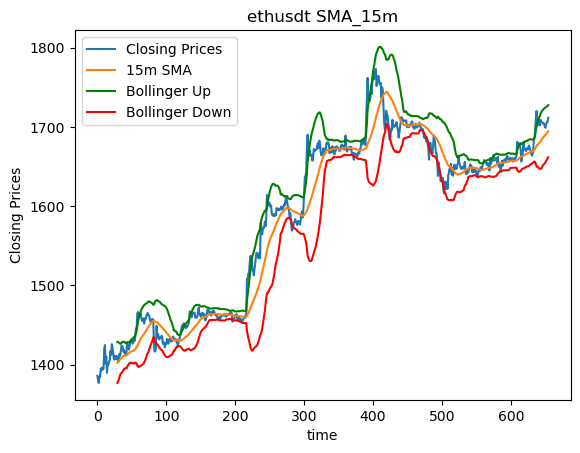

In [13]:
plt.title(symbol + ' SMA_' + str(interval))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(interval) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()